* Main: This notebook contains the file that has tests on how different cuts remove objects on goodspec.
* Updated with 16a 

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import joblib

from astropy.io import fits
from functools import reduce
from astropy.table import Table

sys.path.append('../../methods_code_Nresol/')
sys.path.append('../../utils/')
import astro_cuts
import importlib
import spec_utils

In [2]:
dat = Table.read('lsd_scripts/spectrain_2_11_r50.fits', format='fits')

In [3]:
np.unique(np.array(dat['sdss_dr17_specobj.CLASS']))

array([b'GALAXY', b'QSO', b'STAR'], dtype='|S6')

In [4]:
fname = 'lsd_scripts/spectrain_2_11_r50.fits'
df_allspec = spec_utils.convert_to_dataframe_specmatched(fname)

/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:36: RuntimeWarning: divide by zero encountered in true_divide
  df['reduced_chisq'] = df['chisq'].to_numpy() * n_passbands / (n_passbands - 4)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:40: RuntimeWarning: divide by zero encountered in power
  sdss_flux_sig = np.power(np.array(dat['sdss_dr14_starsweep.psfflux_ivar']), -0.5)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: divide by zero encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]), 0.0, np.inf)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: invalid value encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]),

In [5]:
importlib.reload(spec_utils)

<module 'spec_utils' from '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py'>

In [6]:
df_goodspec = spec_utils.return_goodspec(df_allspec)

Number of objects before / after 596315 210713
c1 = 0.873, c2 = 0.995, c3 = 0.445
Fraction left = 0.353


## Section 1: 
### How many objects are not stars before cuts?

In [7]:
importlib.reload(spec_utils)
#make a table for this instead

<module 'spec_utils' from '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py'>

In [8]:
spec_utils.print_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'])

Number of Stars = 175597, Fraction(%) = 83.3347, Ratio(obj:star)*100 = 100
Number of Galaxies = 299, Fraction(%) = 0.1419, Ratio(obj:star)*100 = 0.1703
Number of QSOs = 34817, Fraction(%) = 16.5234, Ratio(obj:star)*100 = 19.8278


### After cuts: 16a

In [9]:
nbtest_dir = '../../notebooks_test/'

In [10]:
def combine_cuts(df_input, cuts_list):
    cutfuncs = [getattr(astro_cuts, ctup[0]) for ctup in cuts_list]
    masklist = []
    for c, ctup in enumerate(cuts_list):
        if len(ctup)==1:
            masklist.append(cutfuncs[c](df_input))
        else:
            masklist.append(cutfuncs[c](df_input, **ctup[1]))
        print('Cut{} {} {}'.format(c, np.sum(masklist[c]), np.sum(masklist[c])/len(masklist[c])))
    final_cut = reduce(np.logical_and, masklist) #intersection of all cuts
    print('Effective Cut = {:.3f}'.format(np.sum(final_cut)/len(final_cut)))
    return final_cut

In [11]:
os.listdir('models')

['.ipynb_checkpoints',
 'svm_sdss_quasarsep_unbalanced.joblib',
 'svm_panstarrs_quasarsep_balanced.joblib',
 'svm_sdss_quasarsep_balanced.joblib']

In [11]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
smodel = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]

final_cut = combine_cuts(df_goodspec, cuts_list) #intersection of all cuts
df15k = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(df15k['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Cut4 175386 0.8323454177008538
Cut5 156011 0.740395704109381
Effective Cut = 0.667
Number of Stars = 140519, Fraction(%) = 99.9232, Ratio(obj:star)*100 = 100
Number of Galaxies = 55, Fraction(%) = 0.0391, Ratio(obj:star)*100 = 0.0391
Number of QSOs = 53, Fraction(%) = 0.0377, Ratio(obj:star)*100 = 0.0377


In [12]:
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], df15k['sdss_dr17_specobj.CLASS'])

StarFracChange = 16.589 (%)
GalFracChange = -0.103 (%)
QSOFracChange = -16.486 (%)
Stars thrown out = -35078


In [13]:
nbtest_dir

'../../notebooks_test/'

### Ablation Tests: which cut is doing what?

In [14]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5})]

final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Effective Cut = 0.931
Number of Stars = 164022, Fraction(%) = 83.6224, Ratio(obj:star)*100 = 100
Number of Galaxies = 282, Fraction(%) = 0.1438, Ratio(obj:star)*100 = 0.1719
Number of QSOs = 31842, Fraction(%) = 16.2338, Ratio(obj:star)*100 = 19.4132
StarFracChange = 0.288 (%)
GalFracChange = 0.002 (%)
QSOFracChange = -0.290 (%)
Stars thrown out = -11575


In [15]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), ('wise_svmnondetectioncombinedcut', {'model': wisemodel})]

final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Effective Cut = 0.783
Number of Stars = 162841, Fraction(%) = 98.6527, Ratio(obj:star)*100 = 100
Number of Galaxies = 208, Fraction(%) = 0.1260, Ratio(obj:star)*100 = 0.1277
Number of QSOs = 2016, Fraction(%) = 1.2213, Ratio(obj:star)*100 = 1.2380
StarFracChange = 15.318 (%)
GalFracChange = -0.016 (%)
QSOFracChange = -15.302 (%)
Stars thrown out = -12756


In [16]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',)]

final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Effective Cut = 0.781
Number of Stars = 162500, Fraction(%) = 98.6822, Ratio(obj:star)*100 = 100
Number of Galaxies = 154, Fraction(%) = 0.0935, Ratio(obj:star)*100 = 0.0948
Number of QSOs = 2016, Fraction(%) = 1.2243, Ratio(obj:star)*100 = 1.2406
StarFracChange = 15.348 (%)
GalFracChange = -0.048 (%)
QSOFracChange = -15.299 (%)
Stars thrown out = -13097


In [17]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel})]

final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Cut4 175386 0.8323454177008538
Effective Cut = 0.765
Number of Stars = 160589, Fraction(%) = 99.6661, Ratio(obj:star)*100 = 100
Number of Galaxies = 119, Fraction(%) = 0.0739, Ratio(obj:star)*100 = 0.0741
Number of QSOs = 419, Fraction(%) = 0.2600, Ratio(obj:star)*100 = 0.2609
StarFracChange = 16.331 (%)
GalFracChange = -0.068 (%)
QSOFracChange = -16.263 (%)
Stars thrown out = -15008


In [18]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]

final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Cut4 175386 0.8323454177008538
Cut5 156011 0.740395704109381
Effective Cut = 0.667
Number of Stars = 140519, Fraction(%) = 99.9232, Ratio(obj:star)*100 = 100
Number of Galaxies = 55, Fraction(%) = 0.0391, Ratio(obj:star)*100 = 0.0391
Number of QSOs = 53, Fraction(%) = 0.0377, Ratio(obj:star)*100 = 0.0377
StarFracChange = 16.589 (%)
GalFracChange = -0.103 (%)
QSOFracChange = -16.486 (%)
Stars thrown out = -35078


### All cuts except

#### the SDSS ugr cut

In [12]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')

In [13]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('bayestar_chisq', {'maxchisq': 3.0})]

final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Cut4 156011 0.740395704109381
Effective Cut = 0.672
Number of Stars = 141206, Fraction(%) = 99.7683, Ratio(obj:star)*100 = 100
Number of Galaxies = 64, Fraction(%) = 0.0452, Ratio(obj:star)*100 = 0.0453
Number of QSOs = 264, Fraction(%) = 0.1865, Ratio(obj:star)*100 = 0.1870
StarFracChange = 16.434 (%)
GalFracChange = -0.097 (%)
QSOFracChange = -16.337 (%)
Stars thrown out = -34391


In [14]:
smodel = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

#### Redchisq cut

In [16]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel})]


final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 210106 0.997119304456773
Cut4 175386 0.8323454177008538
Effective Cut = 0.765
Number of Stars = 160589, Fraction(%) = 99.6661, Ratio(obj:star)*100 = 100
Number of Galaxies = 119, Fraction(%) = 0.0739, Ratio(obj:star)*100 = 0.0741
Number of QSOs = 419, Fraction(%) = 0.2600, Ratio(obj:star)*100 = 0.2609
StarFracChange = 16.331 (%)
GalFracChange = -0.068 (%)
QSOFracChange = -16.263 (%)
Stars thrown out = -15008


#### WISE cut

In [19]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]


final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 210106 0.997119304456773
Cut3 175386 0.8323454177008538
Cut4 156011 0.740395704109381
Effective Cut = 0.671
Number of Stars = 141184, Fraction(%) = 99.8550, Ratio(obj:star)*100 = 100
Number of Galaxies = 61, Fraction(%) = 0.0431, Ratio(obj:star)*100 = 0.0432
Number of QSOs = 144, Fraction(%) = 0.1018, Ratio(obj:star)*100 = 0.1020
StarFracChange = 16.520 (%)
GalFracChange = -0.099 (%)
QSOFracChange = -16.422 (%)
Stars thrown out = -34413


#### Parallax_nan_edr3

In [20]:
cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]


final_cut = combine_cuts(df_goodspec, cuts_list)
dfalt = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfalt['sdss_dr17_specobj.CLASS'])
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfalt['sdss_dr17_specobj.CLASS'])

Cut0 206622 0.9805849662811502
Cut1 200235 0.9502735948897315
Cut2 176656 0.8383725731207852
Cut3 175386 0.8323454177008538
Cut4 156011 0.740395704109381
Effective Cut = 0.669
Number of Stars = 140802, Fraction(%) = 99.9156, Ratio(obj:star)*100 = 100
Number of Galaxies = 66, Fraction(%) = 0.0468, Ratio(obj:star)*100 = 0.0469
Number of QSOs = 53, Fraction(%) = 0.0376, Ratio(obj:star)*100 = 0.0376
StarFracChange = 16.581 (%)
GalFracChange = -0.095 (%)
QSOFracChange = -16.486 (%)
Stars thrown out = -34795


#### Aside: what eDR3 parallax do the QSOs have?

<Figure size 640x480 with 0 Axes>

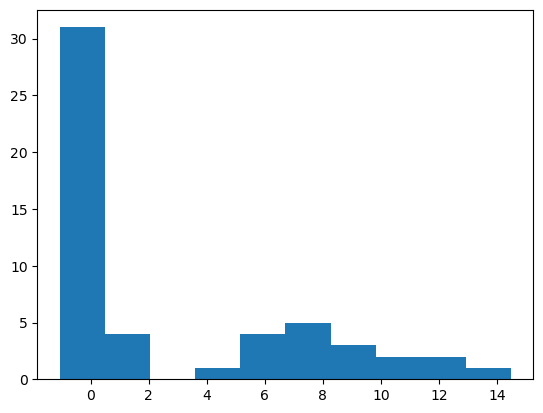

In [22]:
qsomask = (dfalt['sdss_dr17_specobj.CLASS']==b'QSO').to_numpy()
plt.figure()
plt.hist(dfalt.iloc[qsomask]['gaia_edr3.parallax'].to_numpy())
plt.show()

### Color Cuts: z Dbn of objects ONLY removed by the WISE cut and not the sdss cut

In [10]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
smodel = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

In [13]:
df_qsos = df_goodspec.iloc[(df_goodspec['sdss_dr17_specobj.CLASS']==b'QSO').to_numpy()]

In [14]:
len(df_qsos)

34817

In [15]:
wisecut = astro_cuts.wise_svmnondetectioncombinedcut(df_qsos, wisemodel)
sdsscut = astro_cuts.sdss_uvcut(df_qsos, smodel)

In [16]:
wisenotsdss = wisecut * (~sdsscut) #passes WISE cut but not SDSS
sdssnotwise = sdsscut * (~wisecut) #passes SDSS cut but not WISE

In [23]:
np.sum(wisenotsdss), np.sum(sdssnotwise), np.sum(wisecut*sdsscut)

(1714, 1229, 429)

In [20]:
(df_qsos.iloc[wisenotsdss]['allwise.w1mpro']==0).sum()

1672

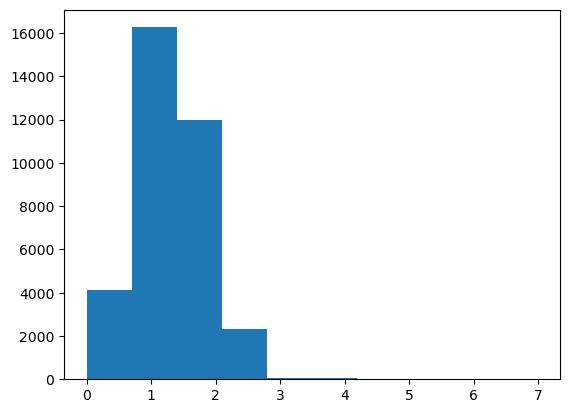

In [24]:
plt.figure()
plt.hist(df_qsos['sdss_dr17_specobj.Z'].to_numpy())
plt.show()

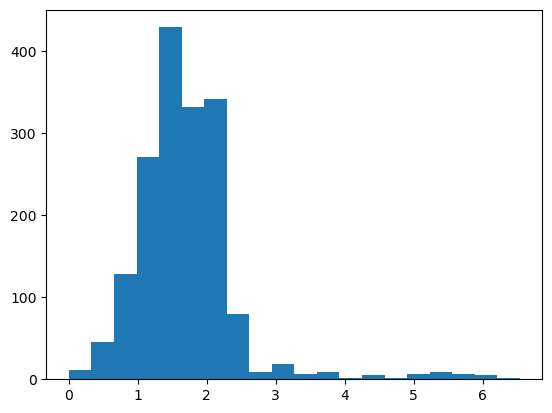

In [37]:
plt.figure()
plt.hist(df_qsos.iloc[wisenotsdss]['sdss_dr17_specobj.Z'].to_numpy(), bins=20) #where the ugr cut is actually needed
plt.show()

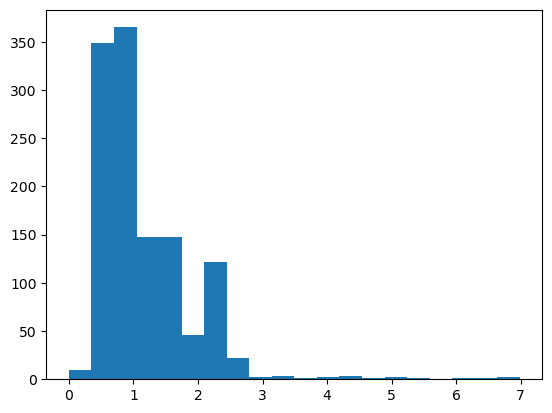

In [38]:
plt.figure()
plt.hist(df_qsos.iloc[sdssnotwise]['sdss_dr17_specobj.Z'].to_numpy(), bins=20) #where the WISE cut is actually needed
plt.show()

In [ ]:
#wise is needed (good) at the lower redshifts <1, and around 2ish

zbinned qsos
* PASS=>Not excluded

In [30]:
zqso = df_qsos['sdss_dr17_specobj.Z'].to_numpy()
zbins = [(zqso<1), ((zqso>=1) * (zqso<1.5)), ((zqso>=1.5) * (zqso<2)), ((zqso>=2) * (zqso<3)), (zqso>=3)]

In [31]:
passboth = []
passwisenotsdss = []
passsdssnotwise = []
passneither = []

for iz, zbin in enumerate(zbins):
    print('Num QSOs = ', np.sum(zbin))
    wiseforbin = wisecut[zbin]
    sdssforbin = sdsscut[zbin]
    passboth.append(np.sum(wiseforbin*sdssforbin))
    passwisenotsdss.append(np.sum(wiseforbin* (~sdssforbin)))
    passsdssnotwise.append(np.sum(sdssforbin * (~wiseforbin)))
    passneither.append(np.sum((~wiseforbin) * (~sdssforbin)))
    assert (passboth[iz] + passwisenotsdss[iz] + passsdssnotwise[iz] + passneither[iz])==np.sum(zbin)

Num QSOs =  10662
Num QSOs =  11937
Num QSOs =  8560
Num QSOs =  3498
Num QSOs =  160


In [32]:
zlabels =['z<1', '1<=z<1.5', '1.5<z<=2', '2<=z<3', '3<=z']

In [46]:
numz = np.array([np.sum(zbin) for zbin in zbins])

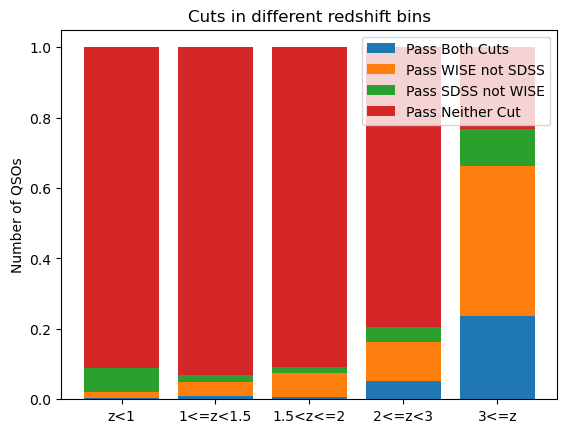

In [56]:
fig, ax = plt.subplots()
ax.bar(zlabels, np.array(passboth)/numz, label='Pass Both Cuts')
ax.bar(zlabels, np.array(passwisenotsdss)/numz, label='Pass WISE not SDSS', bottom=np.array(passboth)/numz)
ax.bar(zlabels, np.array(passsdssnotwise)/numz, label='Pass SDSS not WISE', bottom= (np.array(passboth)/numz + np.array(passwisenotsdss)/numz))
ax.bar(zlabels, np.array(passneither)/numz, label='Pass Neither Cut', bottom=np.array(passboth)/numz + np.array(passwisenotsdss)/numz+np.array(passsdssnotwise)/numz)
ax.set_ylabel('%age of QSOs')
ax.set_title('Cuts in different redshift bins')
ax.legend()

plt.show()

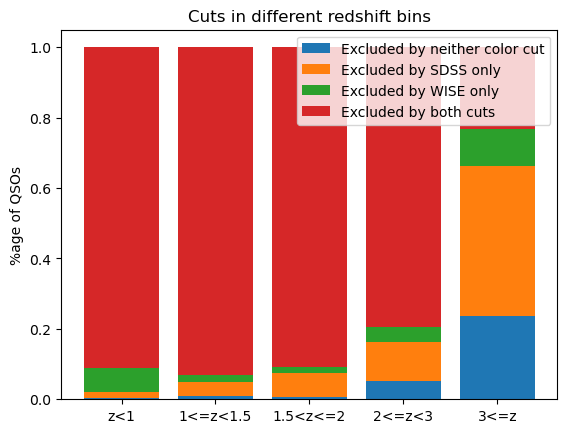

In [63]:
fig, ax = plt.subplots()
ax.bar(zlabels, np.array(passboth)/numz, label='Excluded by neither color cut')
ax.bar(zlabels, np.array(passwisenotsdss)/numz, label='Excluded by SDSS only', bottom=np.array(passboth)/numz)
ax.bar(zlabels, np.array(passsdssnotwise)/numz, label='Excluded by WISE only', bottom= (np.array(passboth)/numz + np.array(passwisenotsdss)/numz))
ax.bar(zlabels, np.array(passneither)/numz, label='Excluded by both cuts', bottom=np.array(passboth)/numz + np.array(passwisenotsdss)/numz+np.array(passsdssnotwise)/numz)
ax.set_ylabel('%age of QSOs')
ax.set_title('Cuts in different redshift bins')
ax.legend()

plt.show()

In [52]:
np.array(passboth)/numz + np.array(passwisenotsdss)/numz + np.array(passsdssnotwise)/numz + np.array(passneither)/numz

array([1., 1., 1., 1., 1.])

In [62]:
noW1qsos = (df_qsos['allwise.w1mpro']==0).to_numpy()

In [64]:
for iz, zbin in enumerate(zbins):
    now1 = noW1qsos[zbin]
    print(zlabels[iz])
    print('Num QSOs = {}. Num W1=0 : {}. %age noW1: {}'.format(np.sum(zbin), now1.sum(), now1.sum()/np.sum(zbin)))

z<1
Num QSOs = 10662. Num W1=0 : 224. %age noW1: 0.021009191521290566
1<=z<1.5
Num QSOs = 11937. Num W1=0 : 582. %age noW1: 0.04875596883639105
1.5<z<=2
Num QSOs = 8560. Num W1=0 : 624. %age noW1: 0.07289719626168224
2<=z<3
Num QSOs = 3498. Num W1=0 : 558. %age noW1: 0.1595197255574614
3<=z
Num QSOs = 160. Num W1=0 : 95. %age noW1: 0.59375


In [65]:
detected_all =  ~(np.isnan(df_qsos['sdss.pmag_u'].to_numpy()) + np.isnan(df_qsos['sdss.pmag_g'].to_numpy()) + np.isnan(
        df_qsos['sdss.pmag_r'].to_numpy()))
sdssmagcols = ['sdss.pmag_u', 'sdss.pmag_g', 'sdss.pmag_r']

# ugr errs < 0.2
sdss_errcols = df_qsos.columns[[c.startswith('sdss.pmag_err_') for c in df_qsos.columns]]
sdss_pmag_err = df_qsos[sdss_errcols].to_numpy()
detected_all *= np.all(sdss_pmag_err[:, :3] < 0.2, axis=1)

# no negative errors
detected_all *= ~np.any(sdss_pmag_err[:, :3] < 0, axis=1)

# saturated on the faint end
detected_all *= ~np.any(df_qsos[sdssmagcols].to_numpy() == 22.5, axis=1)  # nothing should have exactly 22.5

In [66]:
badsdssdetection = ~detected_all

In [68]:
np.sum(badsdssdetection)/len(badsdssdetection)

0.009018582876181175

In [80]:
np.any(sdss_pmag_err<0, axis=1).sum()

19

In [83]:
np.any((sdss_pmag_err[:, :3]>0) * (sdss_pmag_err[:, :3]<0.2), axis=1).sum()/len(df_qsos)

0.9964385214119539

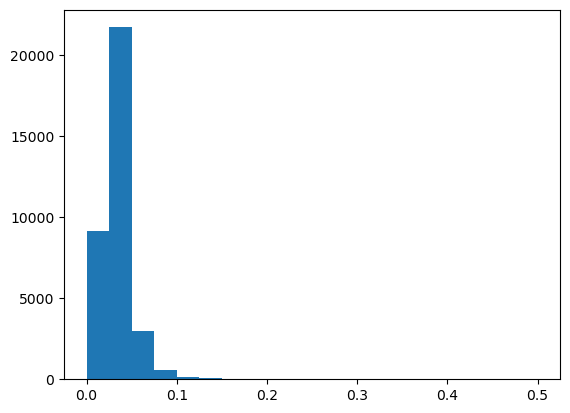

In [75]:
plt.figure()
plt.hist(df_qsos['sdss.pmag_err_u'].to_numpy(), range=[0, 0.5], bins=20)
plt.show()

In [84]:
for iz, zbin in enumerate(zbins):
    nosdss = badsdssdetection[zbin]
    print(zlabels[iz])
    print('Num QSOs = {}. BadSDSS: {}. %age BadSDSS: {}'.format(np.sum(zbin), nosdss.sum(), nosdss.sum()/np.sum(zbin)))

z<1
Num QSOs = 10662. BadSDSS: 96. %age BadSDSS: 0.009003939223410242
1<=z<1.5
Num QSOs = 11937. BadSDSS: 99. %age BadSDSS: 0.008293541090726313
1.5<z<=2
Num QSOs = 8560. BadSDSS: 67. %age BadSDSS: 0.007827102803738318
2<=z<3
Num QSOs = 3498. BadSDSS: 39. %age BadSDSS: 0.011149228130360206
3<=z
Num QSOs = 160. BadSDSS: 13. %age BadSDSS: 0.08125


* Color cuts alone are most effective at the lower z<3 redshift bins
* How many QSOs do not have w1? Overall: 6%, at z> 3 60% and 2<z<3: 16%
* How many have 'poor' ugr? Overall: 9/1000, at z>3 8% and 2<z<3: 1%